<a href="https://colab.research.google.com/github/jvallalta/ia-medicina/blob/main/autoencoders_rxtorax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplicación de autoencoders a radiografías de torax

Utilizaremos imágenes de radiografías de pacientes sanos y con neumonía bacterial extraídas de la competición de Kaggle "Chest X-Ray Images (Pneumonia)".

In [72]:
# Importamos las librerías básicas
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Lambda
import matplotlib.pyplot as plt
import os 

tf.random.set_seed(42)

## Visualización de imágenes

Visualizaremos una muestra aleatoria de las radiografías.

In [44]:
from os import scandir, getcwd

def ls(ruta = getcwd()):
    return [arch.name for arch in scandir(ruta) if arch.is_file()]

In [45]:
imagenes = ls('.')

Imágenes de pacientes sanos


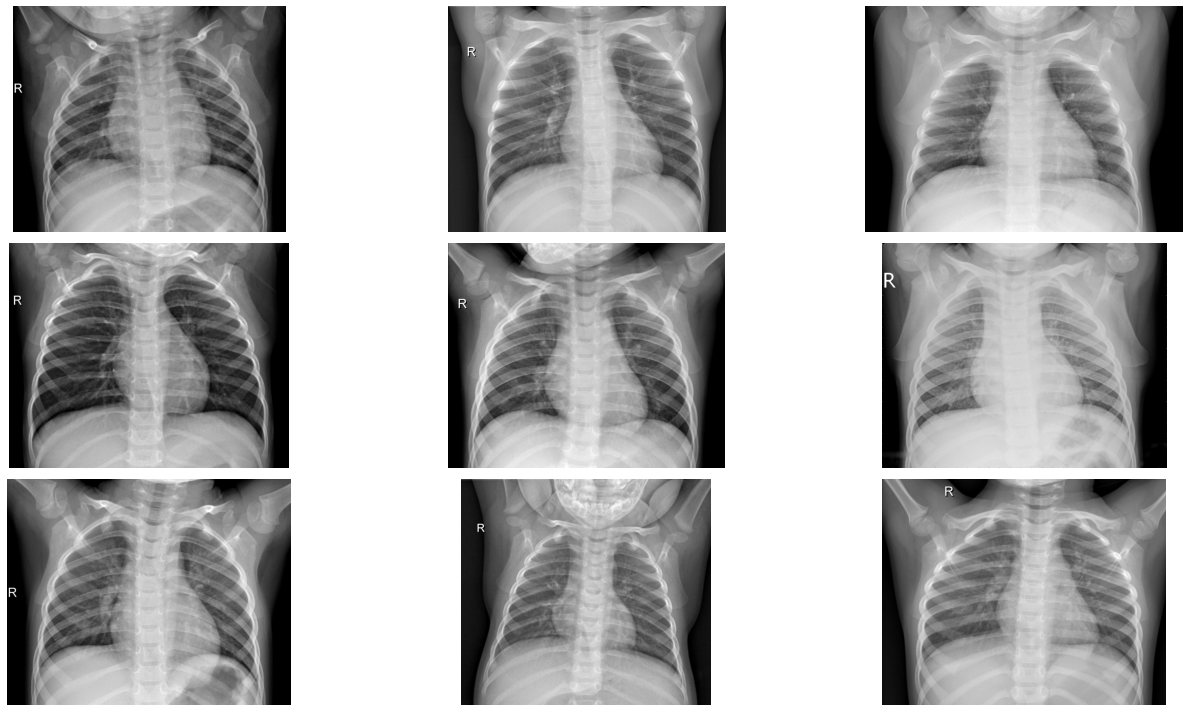

In [46]:
# Se extraen nueve imágenes aleatorias
random_imagenes = [np.random.choice(imagenes) for i in range(9)]

print('Imágenes de pacientes sanos')

# Ajustamos tamaño
plt.figure(figsize=(20,10))

# Mostramos imángenes aleatorias
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(random_imagenes[i])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
# Ajustamos los subplots
plt.tight_layout()    

## Carga y procesamiento de los datos


Vamos a usar la función de Keras ImageDataGenerator para realizar preprocesado de imágenes. Normalizaremos las imágenes y las convertiremos al tamaño 128x128.


In [47]:
imagenes_df = pd.DataFrame(imagenes, columns=['imagen'])

In [76]:
# Importamos data generator
from keras.preprocessing.image import ImageDataGenerator

# Creamos un generador
gen_img = ImageDataGenerator(rescale=1. / 255)

  
# Generador
generador = gen_img.flow_from_directory(directory='.', batch_size=32, color_mode='grayscale', target_size=(256, 256), class_mode='input')


Found 12 images belonging to 4 classes.


In [73]:
#Ejemplo de imagen preprocesada
sns.set_style("white")
imagen_generada =generador.__getitem__(0)
plt.imshow(imagen_generada[0], cmap='gray')
plt.colorbar()
plt.title('Imagen de Rayos X procesada')
print(f"Las dimensiones de la imagen son {imagen_generada.shape[1]} pixels de ancho y {imagen_generada.shape[2]} pixels de alto")
print(f"El valor máximo de pixel es {imagen_generada.max():.4f} y el mínimo es {imagen_generada.min():.4f}")
print(f"El valor medio del pixel es {imagen_generada.mean():.4f} y la desviación estándar es {imagen_generada.std():.4f}")

ValueError: ignored

In [61]:
# Carga
(X_train, y_train), (X_test, _) = tf.keras.datasets.mnist.load_data()
print(' -Entradas Entrenamiento:', X_train.shape)
print(' -Entradas Test:', X_test.shape)

# Normalización
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print('Cambio de dimensiones para ajustar a la entrada de un Perceptrón:')
x_shape = X_train.shape
X_train = X_train.reshape(x_shape[0], x_shape[1]*x_shape[2])
X_test = X_test.reshape(len(X_test), x_shape[1]*x_shape[2])
print(' -Entradas Entrenamiento:', X_train.shape)
print(' -Entradas Test:', X_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
 -Entradas Entrenamiento: (60000, 28, 28)
 -Entradas Test: (10000, 28, 28)
Cambio de dimensiones para ajustar a la entrada de un Perceptrón:
 -Entradas Entrenamiento: (60000, 784)
 -Entradas Test: (10000, 784)


## Autoencoder profundo
### Creación del autoencoder
Vamos a crear un autoencoder que codifique y decodifique la entrada de 728 píxeles en la siguiente secuencia de dimensiones:

784 → 128 → 64 → 32 → 64 → 128 → 784

In [ ]:
# Tamaño de nuestra representación codificada
encoding_dim = 32  # Factor de compresión = 24.5 (dado que la entrada es de tamaño 784)

# Definimos las capas para la entrada, el encoder y el decoder:
# Capa de entrada
input_img = Input(shape=(784,), name='Input')

# Capas del encoder
encoder1 = Dense(128, activation='relu', name='Encoder1')
encoder2 = Dense(64, activation='relu', name='Encoder2')
encoder3 = Dense(encoding_dim, activation='relu', name='Encoder3')

# Capas del decoder
decoder1 = Dense(64, activation='relu', name='Decoder1')
decoder2 = Dense(128, activation='relu', name='Decoder2')
decoder3 = Dense(784, activation='sigmoid', name='Decoder3')

#       Autoencoder
# --------------------------
# "encoded" es la representación codificada de la entrada (cada vez más comprimida)
encoded = encoder1(input_img)
encoded = encoder2(encoded)
encoded = encoder3(encoded)

# "decoded" es la reconstrución de la entrada a partir de la entrada codificada
decoded = decoder1(encoded)
decoded = decoder2(decoded)
decoded = decoder3(decoded)

# Modelo que reconstruye una entrada
autoencoder = tf.keras.Model(input_img, decoded)

# Visualizar arquitectura y dimensiones
print(f"{'*'*65}\n\t\t\tAutoencoder\n{'*'*65}")
autoencoder.summary()

*****************************************************************
			Autoencoder
*****************************************************************
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Encoder1 (Dense)             (None, 128)               100480    
_________________________________________________________________
Encoder2 (Dense)             (None, 64)                8256      
_________________________________________________________________
Encoder3 (Dense)             (None, 32)                2080      
_________________________________________________________________
Decoder1 (Dense)             (None, 64)                2112      
_________________________________________________________________
Decoder2 (Dense)             (None, 128

### Entrenamiento

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
hist= autoencoder.fit(X_train, X_train,
                      epochs=50,
                      batch_size=256,
                      shuffle=True,
                      validation_data=(X_test, X_test))

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2454 - val_loss: 0.1664
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1488 - val_loss: 0.1340
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1284 - val_loss: 0.1214
Epoch 4/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1195 - val_loss: 0.1157
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1149 - val_loss: 0.1115
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1113 - val_loss: 0.1081
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1083 - val_loss: 0.1058
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1054 - val_loss: 0.1027
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1029 - val_loss: 0.1009
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1011 - val_loss: 0.0994

### Evaluación y visualización

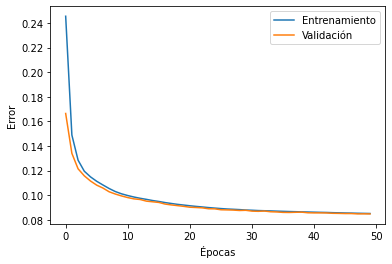

In [ ]:
plt.figure()
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Entrenamiento', 'Validación']);


*****************************************************************
			Encoder
*****************************************************************
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Encoder1 (Dense)             (None, 128)               100480    
_________________________________________________________________
Encoder2 (Dense)             (None, 64)                8256      
_________________________________________________________________
Encoder3 (Dense)             (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


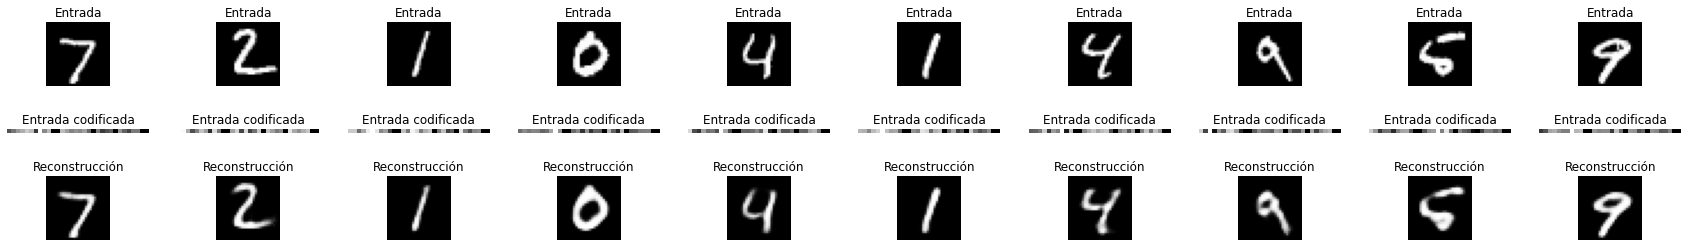

In [ ]:
# Vamos a crear ahora por un lado un modelo para el encoder y otro para el decoder
#          Encoder
# ------------------------
encoder = tf.keras.Model(input_img, encoded)

# Visualizar arquitectura y dimensiones
print(f"\n{'*'*65}\n\t\t\tEncoder\n{'*'*65}")
encoder.summary()

# Codificamos y decodificamos algunos dígitos de ejemplo (datos de test)
# -----------------------
encoded_imgs = encoder.predict(X_test)
decoded_imgs = autoencoder.predict(X_test)
 
n_images = 10 
plt.figure(figsize=(30, 4))
for i in range(n_images):
    # Entrada (original)
    plt.subplot(3, n_images, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title('Entrada')
    plt.axis('off')

    # Codificación
    plt.subplot(3, n_images, i + 1 + n_images)
    plt.imshow(encoded_imgs[i].reshape(1, encoding_dim), cmap='gray')
    plt.axis('off')
    plt.title('Entrada codificada')
    
    # Reconstrucción
    plt.subplot(3, n_images, i + 1 + n_images + n_images)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('Reconstrucción')



## Aplicación: Eliminación de ruido
Para obtener un modelo capaz de eliminar ruido de las imágenes de dígitos vamos a entrenar un autoencoder que mapee imágenes de dígitos con ruido (entrada) a imágenes de dígitos "limpias".

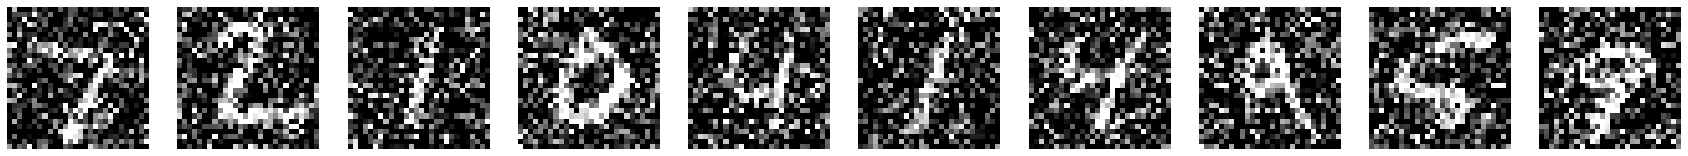

In [ ]:
# Añadimos ruido gaussiano (distribución normal) a las imágenes.
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

# Aseguramos que todos los pixeles queden en el rango [0, 1]
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

# Dibujamos las imágenes con ruido
n_images = 10
plt.figure(figsize=(30, 3))
for i in range(n_images):
    plt.subplot(1, n_images, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

### Creación del modelo y entrenamiento

In [ ]:
# Creación del modelo
encoding_dim = 32
autoencoder = tf.keras.models.Sequential()
autoencoder.add(Dense(units=128, activation='relu', input_shape=(X_train_noisy.shape[1],)))
autoencoder.add(Dense(units=64, activation='relu'))
autoencoder.add(Dense(units=encoding_dim, activation='relu'))
autoencoder.add(Dense(units=64, activation='relu'))
autoencoder.add(Dense(units=128, activation='relu'))
autoencoder.add(Dense(units=X_train_noisy.shape[1], activation='sigmoid'))

# Entrenamiento
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
hist= autoencoder.fit(X_train_noisy, X_train,
                      epochs=50,
                      batch_size=256,
                      shuffle=True,
                      validation_data=(X_test_noisy, X_test))


Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2653 - val_loss: 0.2030
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1821 - val_loss: 0.1684
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1635 - val_loss: 0.1567
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1540 - val_loss: 0.1499
Epoch 5/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1475 - val_loss: 0.1431
Epoch 6/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1423 - val_loss: 0.1399
Epoch 7/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1389 - val_loss: 0.1364
Epoch 8/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1364 - val_loss: 0.1350
Epoch 9/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1342 - val_loss: 0.1326
Epoch 10/50
235/235 [==============================] - 1s 3ms/step - loss: 0.1325 - val_loss: 0.1323

### Evaluación y visualización

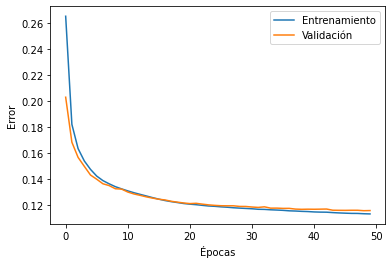

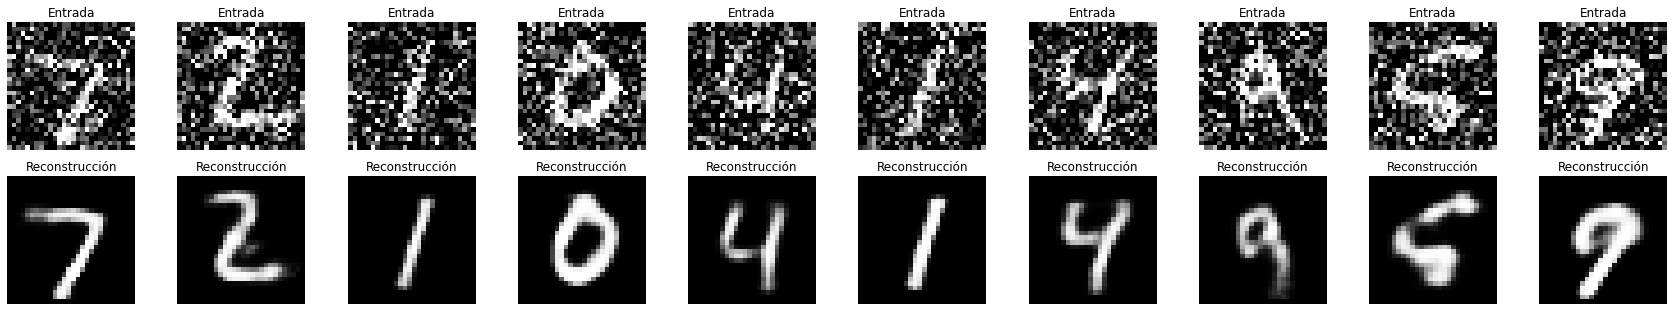

In [ ]:
plt.figure()
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Entrenamiento', 'Validación'])

predictions = autoencoder.predict(X_test)
n_images = 10 
plt.figure(figsize=(30, 8))
for i in range(n_images):
    # Entrada (original)
    plt.subplot(3, n_images, i + 1)
    plt.imshow(X_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title('Entrada')
    plt.axis('off')
    
    # Reconstrucción
    plt.subplot(3, n_images, i + 1 + n_images)
    plt.imshow(predictions[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title('Reconstrucción')

## Autoencoder Variacional
### Creación del Encoder

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self):
    super(Encoder, self).__init__()

    # Capas del encoder
    self.encoder1 = Dense(128, activation='relu', name='Encoder1')
    self.encoder2 = Dense(64, activation='relu', name='Encoder2')
    self.encoder3 = Dense(32, activation='relu', name='Encoder3')

  def call(self, inputs, training=None, mask=None):
    x = self.encoder1(inputs)
    x = self.encoder2(x)
    y = self.encoder3(x)
    return y

### Creación de la capa que representa la distribución normal

In [ ]:
class NormalDistribution(tf.keras.Model):
  def __init__(self):
    super(NormalDistribution, self).__init__()
    
    # Capas
    self.z_mean = Dense(2, name="z_mean", activation='linear')
    self.z_log_var = Dense(2, name="z_log_var", activation='linear')

  def call(self, inputs, training=None, mask=None):
    z_mean = self.z_mean(inputs)
    z_log_var = self.z_log_var(inputs)
    return z_mean, z_log_var


### Creación de la capa de muestreo

In [ ]:
class Reparametrize(tf.keras.layers.Layer):
  """
  Usa (z_mu, z_log_var) para muestrear z (el vector que 
  representa el dígito codificado)
  """
  def call(self, inputs):
    z_mu, z_log_var = inputs
    
    # Extraemos dimensiones (del batch y del espacio codificado)
    batch = tf.shape(z_mu)[0]
    dim = tf.shape(z_mu)[1]
    
    # Muestreamos de una distribucion normal ϵ: con dimensiones (batch, dim_spacio_codificado)
    epsilon = tf.random.normal(shape=(batch, dim))
    
    # Transformamos log(σ^2) en σ 
    sigma = tf.exp(0.5 * z_log_var)

    # Truco de re-parametrización
    reparametrization = z_mu + sigma * epsilon
    
    return reparametrization


### Creación del Decoder

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder, self).__init__()

    # Capas del decoder
    self.decoder1 = Dense(64, activation='relu', name='Decoder1')
    self.decoder2 = Dense(128, activation='relu', name='Decoder2')
    self.decoder3 = Dense(784, activation='sigmoid', name='Decoder3')

  def call(self, inputs,  training=None, mask=None):
    x = self.decoder1(inputs)
    x = self.decoder2(x)
    y = self.decoder3(x)
    return y

### Creación de la función de coste

In [ ]:
class LossVAE(tf.keras.layers.Layer):
  """
  Función de error custom: suma del término de reconstrucción y 
  el término de regularización KL divergence
  """
  def call(self, inputs):
    y_true, y_pred, z_mean, z_log_var = inputs
    
    # Error de reconstrucción (usa categorical_crossentroy)
    reconstruction_loss = tf.reduce_mean(tf.losses.binary_crossentropy(y_true, y_pred))
    reconstruction_loss *= 784
    
    # Divergencia KL
    kl_loss = tf.exp(z_log_var) + tf.square(z_mean) - 1. - z_log_var
    kl_loss = tf.reduce_mean(0.5*tf.reduce_sum(kl_loss, axis=-1))
  
    return reconstruction_loss + kl_loss

### Creación del Autoencoder Variacional

In [ ]:
class VAE(tf.keras.Model):
    def __init__(self):
      super(VAE, self).__init__()
      # Capas del VAE
      self.encoder = Encoder()
      self.normal_distribution = NormalDistribution()
      self.reparametrize = Reparametrize()
      self.decoder = Decoder()
      self.vae_loss = LossVAE()

    def call(self, inputs, training=None, mask=None):
      encoded = self.encoder(inputs)
      z_mean, z_log_var = self.normal_distribution(encoded)
      z = self.reparametrize([z_mean, z_log_var])
      decoded = self.decoder(z)
      return (z_mean, z_log_var, z), decoded

    def train_step(self, data):
      with tf.GradientTape() as tape:
        # Propagación hacia delante
        (z_mean, z_log_var, _), reconstruction = self.call(data)

        total_loss = self.vae_loss([data, reconstruction, z_mean, z_log_var])
         
      # Retro-propagación
      grads = tape.gradient(total_loss, self.trainable_weights)
      
      # Actualización de los pesos
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      
      return {"total_loss": total_loss}

### Entrenamiento del Autoencoder Variacional

In [ ]:
vae = VAE()
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 2s 3ms/step - total_loss: 210.3414
Epoch 2/30
469/469 [==============================] - 2s 3ms/step - total_loss: 174.5014
Epoch 3/30
469/469 [==============================] - 1s 3ms/step - total_loss: 168.4086
Epoch 4/30
469/469 [==============================] - 2s 3ms/step - total_loss: 164.7633
Epoch 5/30
469/469 [==============================] - 1s 3ms/step - total_loss: 161.5496
Epoch 6/30
469/469 [==============================] - 2s 3ms/step - total_loss: 158.7970
Epoch 7/30
469/469 [==============================] - 1s 3ms/step - total_loss: 156.6192
Epoch 8/30
469/469 [==============================] - 1s 3ms/step - total_loss: 155.1522
Epoch 9/30
469/469 [==============================] - 1s 3ms/step - total_loss: 153.8970
Epoch 10/30
469/469 [==============================] - 1s 3ms/step - total_loss: 152.8100
Epoch 11/30
469/469 [==============================] - 2s 3ms/step - total_loss: 151.7592
Epoch 12/30
469/469

### Muestra de Dígitos Generados con el Autoencoder Varacional

In [ ]:
def plot_latent(model, fig_size=15, scale=3.):
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # Creamos un grid 2D linealmente espaciado correspondiente a
    # los dígitos en el espacio codificado
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            # Para cada coordenada 2D del espacio codificado, 
            # usamos el decoder para reconstruir/generar una imagen nueva.
            x_decoded = model.decoder(z_sample).numpy()
            digit = x_decoded.reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size,
                   j * digit_size : (j + 1) * digit_size] = digit

    plt.figure(figsize=(fig_size, fig_size))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="gray")
    plt.show()


def plot_label_clusters(model, data, labels, fig_size=15, scale=3.):
    # Dibujamos un plot 2D the los dígitos y sus clases en el espacio codificado
    encoded = model.encoder(data)
    z_mean, _ = model.normal_distribution(encoded)
    plt.figure(figsize=(fig_size, fig_size))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.xlim((-scale, scale))
    plt.ylim((-scale, scale)) 
    plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



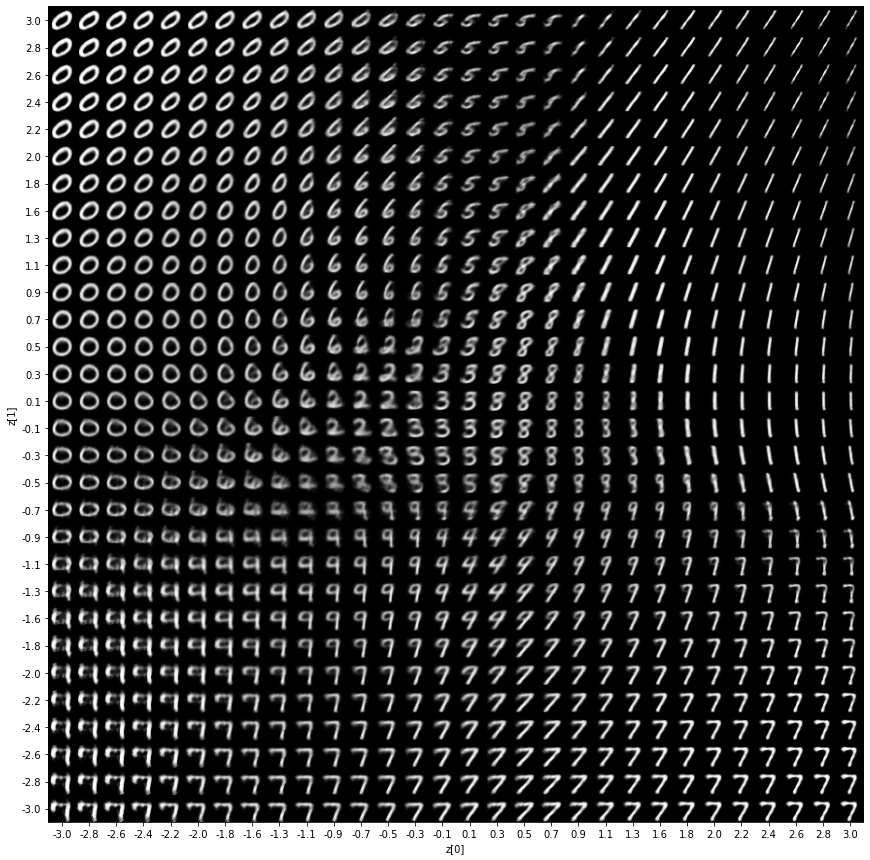

In [ ]:
plot_latent(vae)

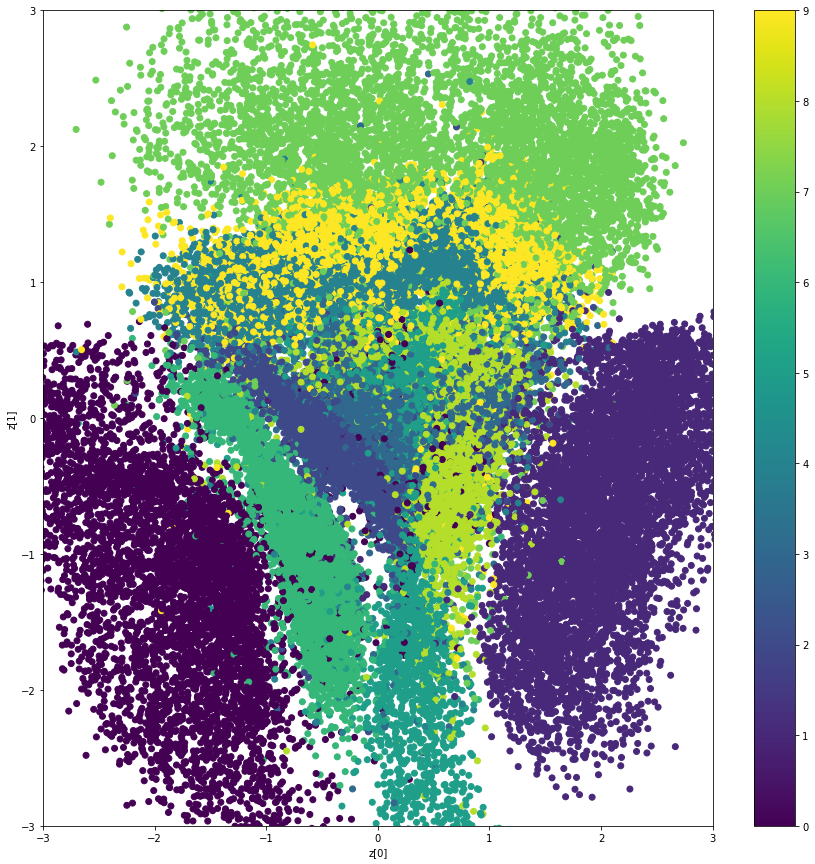

In [ ]:
plot_label_clusters(vae, X_train, y_train)